## 0. Load modules

In [1]:
import pandas as pd
import numpy as np
import os
import pdb
import math
import copy
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import mahalanobis, euclidean
from minisom import MiniSom
import matplotlib.patches as mpatches

pd.set_option('display.max_columns', None)

## 1. Read Data and Create DataFrame

In [2]:
# Creating the empty dataframe with the columns names
datas = pd.DataFrame(columns=["D", "Sub_D", "ID", "Round", "Phase", "BVP", "EDA", "HR", "TEMP", 'participant_ID', 'puzzler', 
                              'team_ID', 'E4_nr', 'upset', 'hostile', 'alert', 'ashamed', 'inspired', 'nervous', 
                              'determined', 'attentive', 'afraid', 'active', 'frustrated', 'difficulty'])

datas.shape

(0, 25)

In [3]:
# Defining path with all directories of the dataset
root_path = "./dataset/"

## ---- Loop to iterate over all directories and store the corresponding data from every participant ---- ##

# First directory (cohort directory)
for var_d in os.listdir(root_path):
    
    d_path = os.path.join(root_path, var_d)
    save_d = var_d[-1]    # Cohort information (1, 2, or 3)
    
    # Condition needed because in cohort 3 (D1_3) there are subdirectories
    if var_d != "D1_3":
        
        # Second directory (only present in cohort 3)
        save_sub_d = '0'
        
        # Third directory (ID directory)
        for var_id in os.listdir(d_path):
            id_path = os.path.join(d_path,var_id)
            save_id = var_id[-1]    # ID_folder information (different for each participant)
            
            # Fourth directory (Round)
            for var_round in os.listdir(id_path):
                round_path = os.path.join(id_path,var_round)
                save_round = var_round[-1]    # Experiment round number (3 rounds for participant)
                
                # Fifth directory (Phase)
                for var_phase in os.listdir(round_path):
                    phase_path = os.path.join(round_path,var_phase)
                    save_phase = var_phase[-1]    # Phase number (4 phases for each round)
                    
                    # Dictionary to keep the physiological measurements
                    beh_dict = dict()
                    # Dataframe for the response answers from the questionnaire
                    resp_df = pd.DataFrame()
                    
                    # Loop to read every variable file (.csv) and store the corresponding measurements/answers
                    for beh_name in os.listdir(phase_path):
                        temp_df = pd.read_csv(os.path.join(phase_path, beh_name))
                        if beh_name.split(".")[0] == "TEMP":
                            beh_dict["TEMP"] = temp_df.TEMP.to_list()
                        elif beh_name.split(".")[0] == "HR":
                            beh_dict["HR"] = temp_df.HR.to_list()
                        elif beh_name.split(".")[0] == "EDA":
                            beh_dict["EDA"] = temp_df.EDA.to_list()
                        elif beh_name.split(".")[0] == "BVP":
                            beh_dict["BVP"] = temp_df.BVP.to_list()
                        elif beh_name.split(".")[0] == "response":
                            resp_df = temp_df.drop(['Unnamed: 0'],axis=1)
                            resp_df.columns.values[0] = 'participant_ID'

                    # First dictionary to create a row of the dataframe (only with the directory and physiological variables)
                    tmp_dict = {
                        "D":[save_d],
                        "Sub_D":[save_sub_d],
                        "ID":[save_id],
                        "Round":[save_round],
                        "Phase":[save_phase],
                        "BVP":[beh_dict["BVP"]],
                        "TEMP":[beh_dict["TEMP"]],
                        "EDA":[beh_dict["EDA"]],
                        "HR":[beh_dict["HR"]],
                    }

                    # Concatenation of the [directory+physiological] dataframe 
                    # with the one corresponding to the [questionnaire answer] dataframe
                    temp_df = pd.DataFrame(tmp_dict)
                    temp_df = pd.concat([temp_df, resp_df], axis=1)    
                    
                    # Adding the complete row to the final dataframe
                    datas = pd.concat([datas, temp_df], axis=0)
                    datas.reset_index(drop=True, inplace=True)
    
    # Condition needed because in cohort 3 (D1_3) there are subdirectories
    else:
        
        # Second directory (only present in cohort 3)
        for var_sub_d in os.listdir(d_path):
            sub_path = os.path.join(d_path,var_sub_d)
            save_sub_d = var_sub_d[-1]
            
            # Third directory (ID directory)
            for var_id in os.listdir(sub_path):
                id_path = os.path.join(sub_path,var_id)
                save_id = var_id[-1]    # ID_folder information (different for each participant)
                
                # Fourth directory (Round)
                for var_round in os.listdir(id_path):
                    round_path = os.path.join(id_path,var_round)
                    save_round = var_round[-1]    # Experiment round number (3 rounds for participant)
                    
                    # Fifth directory (Phase)
                    for var_phase in os.listdir(round_path):
                        phase_path = os.path.join(round_path,var_phase)
                        save_phase = var_phase[-1]    # Phase number (4 phases for each round)
                        
                        # Dictionary to keep the physiological measurements
                        beh_dict = dict()
                        # Dataframe for the response answers from the questionnaire
                        resp_df = pd.DataFrame()
                        
                        # Loop to read every variable file (.csv) and store the corresponding measurements/answers
                        for beh_name in os.listdir(phase_path):
                            temp_df = pd.read_csv(os.path.join(phase_path, beh_name))
                            if beh_name.split(".")[0] == "TEMP":
                                beh_dict["TEMP"] = temp_df.TEMP.to_list()
                            elif beh_name.split(".")[0] == "HR":
                                beh_dict["HR"] = temp_df.HR.to_list()
                            elif beh_name.split(".")[0] == "EDA":
                                beh_dict["EDA"] = temp_df.EDA.to_list()
                            elif beh_name.split(".")[0] == "BVP":
                                beh_dict["BVP"] = temp_df.BVP.to_list()
                            elif beh_name.split(".")[0] == "response":
                                resp_df = temp_df.drop(['Unnamed: 0'],axis=1)
                                resp_df.columns.values[1] = 'puzzler'
                        
                        # First dictionary to create a row of the dataframe (only with the directory and physiological variables)
                        tmp_dict = {
                            "D":[save_d],
                            "Sub_D":[save_sub_d],
                            "ID":[save_id],
                            "Round":[save_round],
                            "Phase":[save_phase],
                            "BVP":[beh_dict["BVP"]],
                            "TEMP":[beh_dict["TEMP"]],
                            "EDA":[beh_dict["EDA"]],
                            "HR":[beh_dict["HR"]],
                        }

                        # Concatenation of the [directory+physiological] dataframe 
                        # with the one corresponding to the [questionnaire answer] dataframe
                        temp_df = pd.DataFrame(tmp_dict)
                        temp_df = pd.concat([temp_df, resp_df], axis=1)
                        
                        # Adding the complete row to the final dataframe
                        datas = pd.concat([datas, temp_df], axis = 0)
                        datas.reset_index(drop=True, inplace=True)

# Update NaN values in the difficulty response for 0 (as this question is only asked in the 2 phase)                        
datas['difficulty'].fillna(0, inplace=True)

# Adding new participant column
datas["participant"] = "D" + datas["D"]+ "_" + datas["Sub_D"] + "_" + "id" + datas["ID"]
datas = datas.astype({'Round':'int'})
datas = datas.astype({'Phase':'int'})

In [4]:
print('Number of rows:', datas.shape[0])
print('Number of columns:', datas.shape[1])

Number of rows: 312
Number of columns: 26


## 2. Pre-processing of the errors in the DataFrame

In [5]:
# Change the wrong difficulty values to 0 (only wrong annotations in phase 3)
datas.loc[(datas['Phase'] == '3') & (datas['difficulty'] != 0), 'difficulty'] = 0

# Check now the values from phases 1 and 3
phase_1 = datas[datas['Phase'] == '1']
phase_3 = datas[datas['Phase'] == '3']
phase_1['difficulty'].value_counts(), phase_3['difficulty'].value_counts()

(Series([], Name: difficulty, dtype: int64),
 Series([], Name: difficulty, dtype: int64))

In [6]:
# Definition of a threshold to remove rows with bad measurements (below 4.5 minutes)

a = np.empty(datas.shape[0])           # Ratio of measurements in 5 minutes (ideally should be 1)
k = 0                                  # Loop counting
true_ = 0                              # Variable to save the number of rows that fulfill the threshold
false_ = 0                             # Variable to save the number of rows that doesn't fulfill the threshold

# Loop to check if each row in the dataframe fulfill the condition
# EDA has 4 measurements each second (HR 1, BVP 64, TEMP 4)
for i in datas['EDA']:
    a[k] = (len(i)/(4*60*5))
    if (a[k] >= 0.9):
        true_ = true_ + 1
    else:
        false_ = false_ + 1
        # print(datas.iloc[k, :5])
        datas = datas.drop(index=k, axis=0)     # Drop the row below the threshold (4.5 minutes)
    k = k + 1
    
print('Above 0.9 (4.5 min = 279 measurements): ', true_)
print('Below 0.9 (4.5 min = 270 measurements): ', false_)

Above 0.9 (4.5 min = 279 measurements):  294
Below 0.9 (4.5 min = 270 measurements):  18


## 3. List Definition of the Physiological Variables

In [7]:
# Function to obtain the list for each physiological variable taking into account the different time steps 
# when measuring each variable (64 BVP_signals/second, 4 TEMP_signlas/second, 4 EDA_signals/second, 1 HR_signal/second)
def create_list_new(original_list, tstep, opt_len):
    
    # Empty results list
    final_list = []
    
    # -- Loop for rearranging the lists into the desired length --
    
    # Condition for the signals with 1 measurement per second (break until get 270 desired length)
    if (tstep == 1):
        for i in range(0, opt_len, 1):
            if len(final_list) == 270:
                break
            final_list.append(original_list[i])
    # Condition for the signals with more than 1 measurement per second (break until get 270 desired length)
    else:
        for i in range(0, len(original_list), tstep):
            if len(final_list) == 270:
                break
            a = sum(original_list[i:i+tstep])/len(original_list[i:i+tstep])
            final_list.append(a)
    return(final_list)

In [8]:
# Create a copy with the desired features
signals_df = datas[["participant", "Round", "Phase", "TEMP", "HR", "BVP", "EDA"]].copy()

# Definition of a dictionary with the correspondant time step for each signal
columns = ['BVP', 'EDA', 'TEMP', 'HR']
time_steps = [64, 4, 4, 1]
dict_tstep = dict(zip(columns, time_steps))    

# Make 300 list for all the features (4.5 min = 270s, 1 measurement per second)
columns = ["TEMP", "HR", "BVP", "EDA"]
for col in columns:
    signals_df[col] = signals_df[col].apply(lambda x: create_list_new(x, dict_tstep[col], 270))

signals_df.head(5)

,participant,Round,Phase,TEMP,HR,BVP,EDA
0,D1_0_id1,1,1,"[30.97, 31.01, 30.97, 30.99, 30.97, 31.01, 30....","[76.75, 76.75, 76.73, 76.72, 76.72, 76.7, 76.7...","[117.4034375, -159.41906249999997, 71.11093749...","[0.19287500000000002, 0.183584, 0.18262275, 0...."
1,D1_0_id1,1,2,"[32.269999999999996, 32.28, 32.27, 32.26000000...","[99.05, 98.98, 98.87, 98.73, 98.62, 98.37, 98....","[-90.75484375, 88.23140625000009, -0.813124999...","[0.36973074999999994, 0.36140075000000005, 0.3..."
2,D1_0_id1,1,3,"[32.965, 32.95, 32.95, 32.95, 32.9150000000000...","[84.42, 84.42, 84.42, 84.43, 84.68, 84.95, 85....","[21.927812499999977, -15.844687500000001, 19.3...","[0.424838, 0.42067324999999994, 0.53345025, 0...."
3,D1_0_id1,2,1,"[33.37, 33.34, 33.37, 33.37, 33.34, 33.37, 33....","[76.33, 76.52, 76.52, 76.58, 76.67, 76.78, 76....","[-30.5634375, 32.24953125000001, -22.580468749...","[0.494683, 0.49083825, 0.49211999999999995, 0...."
4,D1_0_id1,2,2,"[33.7025, 33.68, 33.692499999999995, 33.725, 3...","[83.53, 83.65, 83.85, 84.03, 84.22, 84.42, 84....","[48.4609375, -7.314843749999995, -30.11140625,...","[0.400435, 0.41421174999999993, 0.3975515, 0.3..."


In [9]:
# Check the length of the lists
list_len = []
for col in columns:
    for signal_list in signals_df[col]:
        list_len.append(len(signal_list))
    if all(x == list_len[0] for x in list_len):
        print("All elements in the " + col + " list are the same (" + str(list_len[0]) + ")")
    else:
        print("There are different elements in the " + col + " list")

All elements in the TEMP list are the same (270)
All elements in the HR list are the same (270)
All elements in the BVP list are the same (270)
All elements in the EDA list are the same (270)


## 4. Normalization of the physiological signals

In [10]:
# Extract the signal lists into different variables
all_datas = copy.deepcopy(signals_df)

np_temp = np.array(all_datas.TEMP.to_list())
np_hr = np.array(all_datas.HR.to_list())
np_bvp = np.array(all_datas.BVP.to_list())
np_eda = np.array(all_datas.EDA.to_list())

In [11]:
# Normalization of the signal variables for each time step, taking into account all observations
from sklearn.preprocessing import normalize

nor_temp = normalize(np_temp,axis=0)
nor_hr = normalize(np_hr,axis=0)
nor_bvp = normalize(np_bvp,axis=0)
nor_eda = normalize(np_eda,axis=0)

In [12]:
# Creation of the new dataframe with the normalized variables
norm_signals = copy.deepcopy(all_datas)
for r_idx,(index, row) in enumerate(norm_signals.iterrows()):
    norm_signals.at[index,'TEMP'] = list(nor_temp[r_idx, :])
    norm_signals.at[index,'HR'] = list(nor_hr[r_idx, :])
    norm_signals.at[index,'BVP'] = list(nor_bvp[r_idx, :])
    norm_signals.at[index,'EDA'] = list(nor_eda[r_idx, :])

norm_signals.head(5)

,participant,Round,Phase,TEMP,HR,BVP,EDA
0,D1_0_id1,1,1,"[0.05473091971809032, 0.05479950720180299, 0.0...","[0.054003470728475264, 0.05399018375046446, 0....","[0.11626114289428856, -0.14552122914282697, 0....","[0.0016481043520853906, 0.001553720510941719, ..."
1,D1_0_id1,1,2,"[0.05702831060067079, 0.0570437953071332, 0.05...","[0.06969438144176515, 0.06962799202112016, 0.0...","[-0.08987183069122301, 0.08053956964211931, -0...","[0.003159325253012549, 0.0030586312420729507, ..."
2,D1_0_id1,1,3,"[0.058256531110973446, 0.05822778981939402, 0....","[0.05940029965990726, 0.05938568484969654, 0.0...","[0.021714462512408668, -0.014463379499449676, ...","[0.00363021312627999, 0.0035602702682669156, 0..."
3,D1_0_id1,2,1,"[0.058972256732085046, 0.05891698065488913, 0....","[0.053707946849570254, 0.05382838906300378, 0....","[-0.030266065885235748, 0.029438081953216927, ...","[0.004227034116410407, 0.004154095436311112, 0..."
4,D1_0_id1,2,2,"[0.0595598586308989, 0.05951781369096178, 0.05...","[0.05877407048794188, 0.05884402437428472, 0.0...","[0.04798942943624361, -0.006677150378347791, -...","[0.0034216910757086886, 0.0035055848649558977,..."


In [13]:
# Pivot the dataframe to participant and Round
grouped = norm_signals.groupby(['participant', 'Round'], group_keys=True)
grouped_df = grouped.apply(pd.DataFrame)
grouped_df.head(12)

participant  Round  Phase  \
participant Round                                
D1_0_id1    1     0     D1_0_id1      1      1   
                  1     D1_0_id1      1      2   
                  2     D1_0_id1      1      3   
            2     3     D1_0_id1      2      1   
                  4     D1_0_id1      2      2   
                  5     D1_0_id1      2      3   
            3     6     D1_0_id1      3      1   
                  7     D1_0_id1      3      2   
                  8     D1_0_id1      3      3   
            4     9     D1_0_id1      4      1   
                  10    D1_0_id1      4      2   
                  11    D1_0_id1      4      3   

                                                                   TEMP  \
participant Round                                                         
D1_0_id1    1     0   [0.05473091971809032, 0.05479950720180299, 0.0...   
                  1   [0.05702831060067079, 0.0570437953071332, 0.05...   
                  2   [0.058256531110973446, 0.05822778981939402, 0....   
            2     3   [0.058972256732085046, 0.05891698065488913, 0....   
                  4   [0.0595598586308989, 0.05951781369096178, 0.05...   
                  5   [0.06032418290529588, 0.0603483770055328, 0.06...   
            3     6   [0.061234303139548904, 0.06124079077969954, 0....   
                  7   [0.061552403415598506, 0.061550043077678106, 0...   
                  8   [0.061914684285543885, 0.061938817395136875, 0...   
            4     9   [0.06222394844281434, 0.06219505501346199, 0.0...   
                  10  [0.062453687531072395, 0.062398277952133624, 0...   
                  11  [0.06254204871886394, 0.06253965043120954, 0.0...   

                                                                     HR  \
participant Round                                                         
D1_0_id1    1     0   [0.054003470728475264, 0.05399018375046446, 0....   
                  1   [0.06969438144176515, 0.06962799202112016, 0.0...   
                  2   [0.05940029965990726, 0.05938568484969654, 0.0...   
            2     3   [0.053707946849570254, 0.05382838906300378, 0....   
                  4   [0.05877407048794188, 0.05884402437428472, 0.0...   
                  5   [0.06241182871160594, 0.06234019653376105, 0.0...   
            3     6   [0.06992657877519051, 0.06945212823040203, 0.0...   
                  7   [0.06519116042987927, 0.06504849891082018, 0.0...   
                  8   [0.05987876689242013, 0.05965299781158809, 0.0...   
            4     9   [0.06423422596485352, 0.06462642581309667, 0.0...   
                  10  [0.05719090685095075, 0.057190904741534335, 0....   
                  11  [0.05435528487002885, 0.05437708409004433, 0.0...   

                                                                    BVP  \
participant Round                                                         
D1_0_id1    1     0   [0.11626114289428856, -0.14552122914282697, 0....   
                  1   [-0.08987183069122301, 0.08053956964211931, -0...   
                  2   [0.021714462512408668, -0.014463379499449676, ...   
            2     3   [-0.030266065885235748, 0.029438081953216927, ...   
                  4   [0.04798942943624361, -0.006677150378347791, -...   
                  5   [0.006759832962149317, -0.003770097531792533, ...   
            3     6   [-0.10584999748385139, 0.05534297221205313, 0....   
                  7   [-0.06508242401893534, -0.06925694696393483, 0...   
                  8   [0.0011350973862462878, 0.011479022038880434, ...   
            4     9   [-0.030981072022346443, 0.055098792324245145, ...   
                  10  [-0.012577361796403348, -0.07070590927715997, ...   
                  11  [-0.019725102221382462, -0.07082871236325967, ...   

                                                                    EDA  
participant Round                                                        
D1_0_id1    1     0

## 5. Creation of a time-window dataframe

In [14]:
grouped_df.reset_index(drop=True, inplace=True)
grouped_df

,participant,Round,Phase,TEMP,HR,BVP,EDA
0,D1_0_id1,1,1,"[0.05473091971809032, 0.05479950720180299, 0.0...","[0.054003470728475264, 0.05399018375046446, 0....","[0.11626114289428856, -0.14552122914282697, 0....","[0.0016481043520853906, 0.001553720510941719, ..."
1,D1_0_id1,1,2,"[0.05702831060067079, 0.0570437953071332, 0.05...","[0.06969438144176515, 0.06962799202112016, 0.0...","[-0.08987183069122301, 0.08053956964211931, -0...","[0.003159325253012549, 0.0030586312420729507, ..."
2,D1_0_id1,1,3,"[0.058256531110973446, 0.05822778981939402, 0....","[0.05940029965990726, 0.05938568484969654, 0.0...","[0.021714462512408668, -0.014463379499449676, ...","[0.00363021312627999, 0.0035602702682669156, 0..."
3,D1_0_id1,2,1,"[0.058972256732085046, 0.05891698065488913, 0....","[0.053707946849570254, 0.05382838906300378, 0....","[-0.030266065885235748, 0.029438081953216927, ...","[0.004227034116410407, 0.004154095436311112, 0..."
4,D1_0_id1,2,2,"[0.0595598586308989, 0.05951781369096178, 0.05...","[0.05877407048794188, 0.05884402437428472, 0.0...","[0.04798942943624361, -0.006677150378347791, -...","[0.0034216910757086886, 0.0035055848649558977,..."
...,...,...,...,...,...,...,...
289,D3_4_id2,3,2,"[0.06179981474141487, 0.06176210179629199, 0.0...","[0.05842225634638829, 0.05840788217330377, 0.0...","[0.12814516071744086, -0.06082232895850162, -0...","[0.043445282553959, 0.042986687811676166, 0.04..."
290,D3_4_id2,3,3,"[0.06194119264188136, 0.06192114583525239, 0.0...","[0.05885850588191474, 0.05873850609985384, 0.0...","[0.01645071142425273, -0.00023419589706818845,...","[0.03869834681670598, 0.038290545478226495, 0...."
291,D3_4_id2,4,1,"[0.061835159216531495, 0.06185045959571443, 0....","[0.05660689537597179, 0.05667738247263741, 0.0...","[-0.049478857931337175, -0.021726162248907076,...","[0.05834088814031458, 0.05777787916004606, 0.0..."
292,D3_4_id2,4,2,"[0.06176447026629825, 0.06176210179629199, 0.0...","[0.057401995335882895, 0.057486355909940785, 0...","[0.009438050063912788, 0.02202454094358835, 0....","[0.04700876187355747, 0.04709343126601325, 0.0..."


In [15]:
# Create a dictionary to store the new data for each column
new_data = {}

# Iterate over each column of interest
for col in ['TEMP', 'HR', 'BVP', 'EDA']:
    
    # Create a list of lists to store the new data for this column
    col_data = []

    # Iterate over each row of the column
    for row in grouped_df[col]:
        
        # Create a new list to store the means and standard deviations for this row
        row_stats = []
        
        # Iterate over the 270 items of the list in steps of 15
        for i in range(0, 270, 15):
            
            # Calculate the mean and standard deviation of each 15-item segment
            segment = row[i:i+15]
            mean = np.mean(segment)
            std = np.std(segment)
            
            # Append the mean and standard deviation to the row_stats list
            row_stats.append(mean)
            row_stats.append(std)
            
        # Append the row_stats list to the col_data list
        col_data.append(row_stats)
        
    # Convert the col_data list of lists to a dataframe
    col_df = pd.DataFrame(col_data)

    # Create a list of new column names with means and standard deviations
    new_cols = []
    for i in range(-1, 269, 15):
        new_cols.append(f'{col}_mean_{i+1}')
        new_cols.append(f'{col}_std_{i+1}')
        
    # Rename the columns of the new dataframe
    col_df.columns = new_cols

    # Add the new dataframe to the new_data dictionary
    new_data[col] = col_df

grouped_df.reset_index(drop=True, inplace=True)
    
# Concatenate the original dataframe with the new dataframes
grouped_df = pd.concat([grouped_df] + [new_data[col] for col in new_data], axis=1)
grouped_df = pd.DataFrame(grouped_df)
# Drop the original list columns
grouped_df = grouped_df.drop(columns=['TEMP', 'HR', 'BVP', 'EDA'])

grouped_df

,participant,Round,Phase,TEMP_mean_0,TEMP_std_0,TEMP_mean_15,TEMP_std_15,TEMP_mean_30,TEMP_std_30,TEMP_mean_45,TEMP_std_45,TEMP_mean_60,TEMP_std_60,TEMP_mean_75,TEMP_std_75,TEMP_mean_90,TEMP_std_90,TEMP_mean_105,TEMP_std_105,TEMP_mean_120,TEMP_std_120,TEMP_mean_135,TEMP_std_135,TEMP_mean_150,TEMP_std_150,TEMP_mean_165,TEMP_std_165,TEMP_mean_180,TEMP_std_180,TEMP_mean_195,TEMP_std_195,TEMP_mean_210,TEMP_std_210,TEMP_mean_225,TEMP_std_225,TEMP_mean_240,TEMP_std_240,TEMP_mean_255,TEMP_std_255,HR_mean_0,HR_std_0,HR_mean_15,HR_std_15,HR_mean_30,HR_std_30,HR_mean_45,HR_std_45,HR_mean_60,HR_std_60,HR_mean_75,HR_std_75,HR_mean_90,HR_std_90,HR_mean_105,HR_std_105,HR_mean_120,HR_std_120,HR_mean_135,HR_std_135,HR_mean_150,HR_std_150,HR_mean_165,HR_std_165,HR_mean_180,HR_std_180,HR_mean_195,HR_std_195,HR_mean_210,HR_std_210,HR_mean_225,HR_std_225,HR_mean_240,HR_std_240,HR_mean_255,HR_std_255,BVP_mean_0,BVP_std_0,BVP_mean_15,BVP_std_15,BVP_mean_30,BVP_std_30,BVP_mean_45,BVP_std_45,BVP_mean_60,BVP_std_60,BVP_mean_75,BVP_std_75,BVP_mean_90,BVP_std_90,BVP_mean_105,BVP_std_105,BVP_mean_120,BVP_std_120,BVP_mean_135,BVP_std_135,BVP_mean_150,BVP_std_150,BVP_mean_165,BVP_std_165,BVP_mean_180,BVP_std_180,BVP_mean_195,BVP_std_195,BVP_mean_210,BVP_std_210,BVP_mean_225,BVP_std_225,BVP_mean_240,BVP_std_240,BVP_mean_255,BVP_std_255,EDA_mean_0,EDA_std_0,EDA_mean_15,EDA_std_15,EDA_mean_30,EDA_std_30,EDA_mean_45,EDA_std_45,EDA_mean_60,EDA_std_60,EDA_mean_75,EDA_std_75,EDA_mean_90,EDA_std_90,EDA_mean_105,EDA_std_105,EDA_mean_120,EDA_std_120,EDA_mean_135,EDA_std_135,EDA_mean_150,EDA_std_150,EDA_mean_165,EDA_std_165,EDA_mean_180,EDA_std_180,EDA_mean_195,EDA_std_195,EDA_mean_210,EDA_std_210,EDA_mean_225,EDA_std_225,EDA_mean_240,EDA_std_240,EDA_mean_255,EDA_std_255
0,D1_0_id1,1,1,0.054804,0.000057,0.054986,0.000042,0.055281,0.000225,0.055440,0.000037,0.055410,0.000022,0.055409,0.000022,0.055406,0.000028,0.055467,0.000032,0.055448,0.000046,0.055396,0.000018,0.055366,0.000031,0.055339,0.000030,0.055303,0.000025,0.055270,0.000028,0.055248,0.000022,0.055214,0.000019,0.055194,0.000028,0.055169,0.000027,0.053993,0.000036,0.053654,0.000206,0.053662,0.000217,0.054102,0.000356,0.054944,0.000592,0.056465,0.000255,0.056501,0.000292,0.056208,0.000371,0.057404,0.000269,0.058330,0.000662,0.061128,0.000573,0.062689,0.000266,0.062046,0.000391,0.060318,0.000953,0.058007,0.000156,0.057383,0.000120,0.057303,0.000038,0.058031,0.000394,-0.002207,0.063138,-0.000154,0.029898,0.001776,0.063569,-0.000258,0.004483,-0.000491,0.005720,-0.000971,0.018613,0.003465,0.029853,0.006487,0.040939,-0.006763,0.025580,0.000136,0.004125,0.000783,0.003915,-0.000257,0.004144,-0.000299,0.003961,0.000658,0.005844,-0.001168,0.005827,-0.000123,0.005110,0.001002,0.007259,-0.000858,0.005282,0.001542,0.000044,0.001511,0.000025,0.001541,0.000034,0.001633,0.000010,0.001634,0.000006,0.001658,0.000014,0.001703,0.000044,0.001684,0.000037,0.001798,0.000055,0.001849,0.000009,0.001900,0.000019,0.001950,0.000019,0.001965,0.000007,0.001945,0.000007,0.001955,0.000007,0.001946,0.000013,0.002007,0.000016,0.002017,0.000008
1,D1_0_id1,1,2,0.057053,0.000024,0.057155,0.000034,0.057249,0.000022,0.057282,0.000016,0.057345,0.000022,0.057403,0.000022,0.057454,0.000025,0.057512,0.000024,0.057561,0.000018,0.057608,0.000021,0.057672,0.000020,0.057712,0.000012,0.057782,0.000018,0.057837,0.000024,0.057855,0.000011,0.057845,0.000012,0.057855,0.000020,0.057886,0.000020,0.068362,0.001157,0.063305,0.001404,0.060000,0.000526,0.059655,0.000205,0.059714,0.000682,0.062008,0.000649,0.064165,0.000558,0.064688,0.000245,0.063490,0.001082,0.059657,0.000954,0.056796,0.000538,0.055108,0.000375,0.056476,0.000885,0.059612,0.000851,0.061757,0.000316,0.063341,0.000419,0.063474,0.000148,0.063751,0.000083,-0.000746,0.035191,-0.000786,0.022240,-0.000306,0.012270,-0.001345,0.009551,0.000055,0.022892,0.003000,0.019408,-0.002177,0.031521,-0.000182,0.024855,-0.000453,0.037947,-0.000198,0.030379,0.003282,0.024781,-0.000487,0.032808,-0.000045,0.018738,-0.002229,

## 6. Group new dataframe with the questionnaire responses

In [16]:
# Creation of a dataframe with the response variables (removing some variables that are not of interest in this analysis)
resp_team_df = datas.drop(columns=['D', 'Sub_D', 'ID', 'Round', 'Phase', 'BVP', 'EDA', 'HR', 'TEMP', 'participant_ID', 'E4_nr', 'participant'])

# Creation of a dataframe with the response variables (removing also 'team_ID' information)
resp_df = datas.drop(columns=['D', 'Sub_D', 'ID', 'Round', 'Phase', 'BVP', 'EDA', 'HR', 'TEMP', 'participant_ID', 'team_ID', 'E4_nr', 'participant'])
resp_df

,puzzler,upset,hostile,alert,ashamed,inspired,nervous,determined,attentive,afraid,active,frustrated,difficulty
0,1,1,1,2,1,2,2,3,3,1,2,1,0.0
1,1,1,1,1,1,3,1,3,2,1,3,2,5.0
2,1,1,1,1,1,2,1,2,2,1,1,3,0.0
3,1,1,1,1,1,2.0,1,3,2,1,1,4,0.0
4,1,1,1,2,1,2,1,3,3,1,3,1,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,0,1,1,2,1,2,1,2,2,1,2,0,1.0
308,0,1,1,1,1,1,1,1,1,1,1,0,0.0
309,0,1,1,2,1,2,1,2,2,1,2,0,0.0
310,0,1,1,2,1,2,2,2,2,1,2,1,2.0


In [17]:
## -- Transform team_ID information into categorical and one-hot-encoding --

# Convert the team_ID column to categorical data type
resp_team_df['team_ID'] = resp_team_df['team_ID'].astype('category')

# One-hot-encode the team_ID column
resp_team_1hot_df = pd.get_dummies(resp_team_df['team_ID'], prefix='team_ID')

# Concatenate the original DataFrame with the new one-hot-encoded DataFrame
resp_team_1hot_df = pd.concat([resp_team_df, resp_team_1hot_df], axis=1)
resp_team_1hot_df = resp_team_1hot_df.drop(columns=['team_ID'])

In [18]:
# Getting the names of the columns to future normalization
resp_norm_columns = resp_df.columns.tolist()[1:13]
resp_norm_columns

['upset',
 'hostile',
 'alert',
 'ashamed',
 'inspired',
 'nervous',
 'determined',
 'attentive',
 'afraid',
 'active',
 'frustrated',
 'difficulty']

In [19]:
# Concatenate physiological time-window and response dataframes
joint_team_df = pd.concat([grouped_df.reset_index(drop=True), resp_team_1hot_df.reset_index(drop=True)], axis=1)

# Concatenate physiological time-window and response dataframes (no team_ID)
joint_df = pd.concat([grouped_df.reset_index(drop=True), resp_df.reset_index(drop=True)], axis=1)
joint_df

,participant,Round,Phase,TEMP_mean_0,TEMP_std_0,TEMP_mean_15,TEMP_std_15,TEMP_mean_30,TEMP_std_30,TEMP_mean_45,TEMP_std_45,TEMP_mean_60,TEMP_std_60,TEMP_mean_75,TEMP_std_75,TEMP_mean_90,TEMP_std_90,TEMP_mean_105,TEMP_std_105,TEMP_mean_120,TEMP_std_120,TEMP_mean_135,TEMP_std_135,TEMP_mean_150,TEMP_std_150,TEMP_mean_165,TEMP_std_165,TEMP_mean_180,TEMP_std_180,TEMP_mean_195,TEMP_std_195,TEMP_mean_210,TEMP_std_210,TEMP_mean_225,TEMP_std_225,TEMP_mean_240,TEMP_std_240,TEMP_mean_255,TEMP_std_255,HR_mean_0,HR_std_0,HR_mean_15,HR_std_15,HR_mean_30,HR_std_30,HR_mean_45,HR_std_45,HR_mean_60,HR_std_60,HR_mean_75,HR_std_75,HR_mean_90,HR_std_90,HR_mean_105,HR_std_105,HR_mean_120,HR_std_120,HR_mean_135,HR_std_135,HR_mean_150,HR_std_150,HR_mean_165,HR_std_165,HR_mean_180,HR_std_180,HR_mean_195,HR_std_195,HR_mean_210,HR_std_210,HR_mean_225,HR_std_225,HR_mean_240,HR_std_240,HR_mean_255,HR_std_255,BVP_mean_0,BVP_std_0,BVP_mean_15,BVP_std_15,BVP_mean_30,BVP_std_30,BVP_mean_45,BVP_std_45,BVP_mean_60,BVP_std_60,BVP_mean_75,BVP_std_75,BVP_mean_90,BVP_std_90,BVP_mean_105,BVP_std_105,BVP_mean_120,BVP_std_120,BVP_mean_135,BVP_std_135,BVP_mean_150,BVP_std_150,BVP_mean_165,BVP_std_165,BVP_mean_180,BVP_std_180,BVP_mean_195,BVP_std_195,BVP_mean_210,BVP_std_210,BVP_mean_225,BVP_std_225,BVP_mean_240,BVP_std_240,BVP_mean_255,BVP_std_255,EDA_mean_0,EDA_std_0,EDA_mean_15,EDA_std_15,EDA_mean_30,EDA_std_30,EDA_mean_45,EDA_std_45,EDA_mean_60,EDA_std_60,EDA_mean_75,EDA_std_75,EDA_mean_90,EDA_std_90,EDA_mean_105,EDA_std_105,EDA_mean_120,EDA_std_120,EDA_mean_135,EDA_std_135,EDA_mean_150,EDA_std_150,EDA_mean_165,EDA_std_165,EDA_mean_180,EDA_std_180,EDA_mean_195,EDA_std_195,EDA_mean_210,EDA_std_210,EDA_mean_225,EDA_std_225,EDA_mean_240,EDA_std_240,EDA_mean_255,EDA_std_255,puzzler,upset,hostile,alert,ashamed,inspired,nervous,determined,attentive,afraid,active,frustrated,difficulty
0,D1_0_id1,1,1,0.054804,0.000057,0.054986,0.000042,0.055281,0.000225,0.055440,0.000037,0.055410,0.000022,0.055409,0.000022,0.055406,0.000028,0.055467,0.000032,0.055448,0.000046,0.055396,0.000018,0.055366,0.000031,0.055339,0.000030,0.055303,0.000025,0.055270,0.000028,0.055248,0.000022,0.055214,0.000019,0.055194,0.000028,0.055169,0.000027,0.053993,0.000036,0.053654,0.000206,0.053662,0.000217,0.054102,0.000356,0.054944,0.000592,0.056465,0.000255,0.056501,0.000292,0.056208,0.000371,0.057404,0.000269,0.058330,0.000662,0.061128,0.000573,0.062689,0.000266,0.062046,0.000391,0.060318,0.000953,0.058007,0.000156,0.057383,0.000120,0.057303,0.000038,0.058031,0.000394,-0.002207,0.063138,-0.000154,0.029898,0.001776,0.063569,-0.000258,0.004483,-0.000491,0.005720,-0.000971,0.018613,0.003465,0.029853,0.006487,0.040939,-0.006763,0.025580,0.000136,0.004125,0.000783,0.003915,-0.000257,0.004144,-0.000299,0.003961,0.000658,0.005844,-0.001168,0.005827,-0.000123,0.005110,0.001002,0.007259,-0.000858,0.005282,0.001542,0.000044,0.001511,0.000025,0.001541,0.000034,0.001633,0.000010,0.001634,0.000006,0.001658,0.000014,0.001703,0.000044,0.001684,0.000037,0.001798,0.000055,0.001849,0.000009,0.001900,0.000019,0.001950,0.000019,0.001965,0.000007,0.001945,0.000007,0.001955,0.000007,0.001946,0.000013,0.002007,0.000016,0.002017,0.000008,1,1,1,2,1,2,2,3,3,1,2,1,0.0
1,D1_0_id1,1,2,0.057053,0.000024,0.057155,0.000034,0.057249,0.000022,0.057282,0.000016,0.057345,0.000022,0.057403,0.000022,0.057454,0.000025,0.057512,0.000024,0.057561,0.000018,0.057608,0.000021,0.057672,0.000020,0.057712,0.000012,0.057782,0.000018,0.057837,0.000024,0.057855,0.000011,0.057845,0.000012,0.057855,0.000020,0.057886,0.000020,0.068362,0.001157,0.063305,0.001404,0.060000,0.000526,0.059655,0.000205,0.059714,0.000682,0.062008,0.000649,0.064165,0.000558,0.064688,0.000245,0.063490,0.001082,0.059657,0.000954,0.056796,0.000538,0.055108,0.000375,0.056476,0.000885,0.059612,0.000851,0.061757,0.000316,0.063341,0.000419,0.063474,0.000148,0.063751,0.000083,-0.000746,0.035191,-0.000786,0.022240,-0.000306,0.012270,-0.001345,0.009551,0.000055,0.022892,0.003000,0.019408,-0.0

In [20]:
# Correcting missing values

joint_corrected_df = pd.DataFrame(columns=joint_df.columns.tolist())
joint_corrected_team_df = pd.DataFrame(columns=joint_team_df.columns.tolist())

# Loop for each unique participant ID
for ind in joint_df['participant'].unique():
    
    # Store a dataframe with the rows corresponding to each participant
    ind_team_df = joint_team_df[joint_team_df['participant'] == ind]
    ind_df = joint_df[joint_df['participant'] == ind]
    
    for col in ind_team_df.columns:
        if ind_team_df[col].isna().any():
            phase_mean = ind_team_df.groupby('Phase')[col].transform('mean')
            ind_team_df.loc[ind_team_df[col].isna(), col] = phase_mean[ind_team_df[col].isna()]

    for col in ind_df.columns:
        if ind_df[col].isna().any():
            phase_mean = ind_df.groupby('Phase')[col].transform('mean')
            ind_df.loc[ind_df[col].isna(), col] = phase_mean[ind_df[col].isna()]
    
    joint_corrected_team_df = pd.concat([joint_corrected_team_df, ind_team_df], ignore_index=True)
    joint_corrected_df = pd.concat([joint_corrected_df, ind_df], ignore_index=True)

# Normalization of the columns
joint_corrected_team_df[resp_norm_columns] = normalize(joint_corrected_team_df[resp_norm_columns], axis=0)
joint_corrected_df[resp_norm_columns] = normalize(joint_corrected_df[resp_norm_columns], axis=0)

joint_corrected_team_df

,participant,Round,Phase,TEMP_mean_0,TEMP_std_0,TEMP_mean_15,TEMP_std_15,TEMP_mean_30,TEMP_std_30,TEMP_mean_45,TEMP_std_45,TEMP_mean_60,TEMP_std_60,TEMP_mean_75,TEMP_std_75,TEMP_mean_90,TEMP_std_90,TEMP_mean_105,TEMP_std_105,TEMP_mean_120,TEMP_std_120,TEMP_mean_135,TEMP_std_135,TEMP_mean_150,TEMP_std_150,TEMP_mean_165,TEMP_std_165,TEMP_mean_180,TEMP_std_180,TEMP_mean_195,TEMP_std_195,TEMP_mean_210,TEMP_std_210,TEMP_mean_225,TEMP_std_225,TEMP_mean_240,TEMP_std_240,TEMP_mean_255,TEMP_std_255,HR_mean_0,HR_std_0,HR_mean_15,HR_std_15,HR_mean_30,HR_std_30,HR_mean_45,HR_std_45,HR_mean_60,HR_std_60,HR_mean_75,HR_std_75,HR_mean_90,HR_std_90,HR_mean_105,HR_std_105,HR_mean_120,HR_std_120,HR_mean_135,HR_std_135,HR_mean_150,HR_std_150,HR_mean_165,HR_std_165,HR_mean_180,HR_std_180,HR_mean_195,HR_std_195,HR_mean_210,HR_std_210,HR_mean_225,HR_std_225,HR_mean_240,HR_std_240,HR_mean_255,HR_std_255,BVP_mean_0,BVP_std_0,BVP_mean_15,BVP_std_15,BVP_mean_30,BVP_std_30,BVP_mean_45,BVP_std_45,BVP_mean_60,BVP_std_60,BVP_mean_75,BVP_std_75,BVP_mean_90,BVP_std_90,BVP_mean_105,BVP_std_105,BVP_mean_120,BVP_std_120,BVP_mean_135,BVP_std_135,BVP_mean_150,BVP_std_150,BVP_mean_165,BVP_std_165,BVP_mean_180,BVP_std_180,BVP_mean_195,BVP_std_195,BVP_mean_210,BVP_std_210,BVP_mean_225,BVP_std_225,BVP_mean_240,BVP_std_240,BVP_mean_255,BVP_std_255,EDA_mean_0,EDA_std_0,EDA_mean_15,EDA_std_15,EDA_mean_30,EDA_std_30,EDA_mean_45,EDA_std_45,EDA_mean_60,EDA_std_60,EDA_mean_75,EDA_std_75,EDA_mean_90,EDA_std_90,EDA_mean_105,EDA_std_105,EDA_mean_120,EDA_std_120,EDA_mean_135,EDA_std_135,EDA_mean_150,EDA_std_150,EDA_mean_165,EDA_std_165,EDA_mean_180,EDA_std_180,EDA_mean_195,EDA_std_195,EDA_mean_210,EDA_std_210,EDA_mean_225,EDA_std_225,EDA_mean_240,EDA_std_240,EDA_mean_255,EDA_std_255,puzzler,upset,hostile,alert,ashamed,inspired,nervous,determined,attentive,afraid,active,frustrated,difficulty,team_ID_1,team_ID_2,team_ID_3,team_ID_4,team_ID_8,team_ID_9,team_ID_10,team_ID_11,team_ID_12,team_ID_13
0,D1_0_id1,1,1,0.054804,0.000057,0.054986,0.000042,0.055281,0.000225,0.055440,0.000037,0.055410,0.000022,0.055409,0.000022,0.055406,0.000028,0.055467,0.000032,0.055448,0.000046,0.055396,0.000018,0.055366,0.000031,0.055339,0.000030,0.055303,0.000025,0.055270,0.000028,0.055248,0.000022,0.055214,0.000019,0.055194,0.000028,0.055169,0.000027,0.053993,0.000036,0.053654,0.000206,0.053662,0.000217,0.054102,0.000356,0.054944,0.000592,0.056465,0.000255,0.056501,0.000292,0.056208,0.000371,0.057404,0.000269,0.058330,0.000662,0.061128,0.000573,0.062689,0.000266,0.062046,0.000391,0.060318,0.000953,0.058007,0.000156,0.057383,0.000120,0.057303,0.000038,0.058031,0.000394,-0.002207,0.063138,-0.000154,0.029898,0.001776,0.063569,-0.000258,0.004483,-0.000491,0.005720,-0.000971,0.018613,0.003465,0.029853,0.006487,0.040939,-0.006763,0.025580,0.000136,0.004125,0.000783,0.003915,-0.000257,0.004144,-0.000299,0.003961,0.000658,0.005844,-0.001168,0.005827,-0.000123,0.005110,0.001002,0.007259,-0.000858,0.005282,0.001542,0.000044,0.001511,0.000025,0.001541,0.000034,0.001633,0.000010,0.001634,0.000006,0.001658,0.000014,0.001703,0.000044,0.001684,0.000037,0.001798,0.000055,0.001849,0.000009,0.001900,0.000019,0.001950,0.000019,0.001965,0.000007,0.001945,0.000007,0.001955,0.000007,0.001946,0.000013,0.002007,0.000016,0.002017,0.000008,1,0.038837,0.053149,0.048182,0.042993,0.048113,0.077850,0.056097,0.05865,0.053683,0.041651,0.020274,0.000000,0,1,0,0,0,0,0,0,0,0
1,D1_0_id1,1,2,0.057053,0.000024,0.057155,0.000034,0.057249,0.000022,0.057282,0.000016,0.057345,0.000022,0.057403,0.000022,0.057454,0.000025,0.057512,0.000024,0.057561,0.000018,0.057608,0.000021,0.057672,0.000020,0.057712,0.000012,0.057782,0.000018,0.057837,0.000024,0.057855,0.000011,0.057845,0.000012,0.057855,0.000020,0.057886,0.000020,0.068362,0.001157,0.063305,0.001404,0.060000,0.000526,0.059655,0.000205,0.059714,0.000682,0.062008,0.000649,0.064165,0.000558,0.064688,0.000245,0.063490,0.001082,0.059657,0.000954,0.056796,0.000538,0.055108,0.000375,0.056476,0.000885,0

## 7. Group all rounds and phases together

In [21]:
# -- Loop to group all rounds together --

cont = 0   # Counting variable

# Loop for each unique participant ID
for ind in joint_corrected_df['participant'].unique():
    
    # Store a dataframe with the rows corresponding to each participant
    ind_team_df = joint_corrected_team_df[joint_corrected_team_df['participant'] == ind]
    ind_df = joint_corrected_df[joint_corrected_df['participant'] == ind]
    
    # Define the names of the final dataframe with all the rounds together
    col_team_names = list(ind_team_df.columns)
    col_names = list(ind_df.columns)
    new_col_team_names = col_team_names[:1] + col_team_names[2:]
    new_col_names = col_names[:1] + col_names[2:]

    # Define the empty final dataframe only in the first round
    if (cont == 0):
        joint_phases_team_df = pd.DataFrame(columns=new_col_team_names)
        joint_phases_df = pd.DataFrame(columns=new_col_names)
    
    # Loop for each phases inside each individual
    for phase in range(0, 3, 1):
        
        # Store a dataframe with the rows corresponding to each phase (ideally 4 rows as there are 4 phases)
        ind_phase_team_df = ind_team_df[ind_team_df['Phase'] == (phase+1) ]
        ind_phase_df = ind_df[ind_df['Phase'] == (phase+1) ]
        
        # Keep the array of the measurement/response variables to perform the mean over all rounds
        values_team_array = ind_phase_team_df.drop(columns=['participant', 'Round', 'Phase']).values
        new_row_team = np.mean(values_team_array, axis=0, keepdims=True)
        values_array = ind_phase_df.drop(columns=['participant', 'Round', 'Phase']).values
        new_row = np.mean(values_array, axis=0, keepdims=True)
        
        # Insert the participant and phase information
        new_row_team = np.insert(new_row_team, 0, ind)
        new_row_team = np.insert(new_row_team, 1, (phase+1))
        new_row = np.insert(new_row, 0, ind)
        new_row = np.insert(new_row, 1, (phase+1))
        
        # Insert the row in the final dataframe
        joint_phases_team_df.loc[len(joint_phases_team_df)] = new_row_team
        joint_phases_df.loc[len(joint_phases_df)] = new_row
    
    cont += 1
    
joint_phases_df

,participant,Phase,TEMP_mean_0,TEMP_std_0,TEMP_mean_15,TEMP_std_15,TEMP_mean_30,TEMP_std_30,TEMP_mean_45,TEMP_std_45,TEMP_mean_60,TEMP_std_60,TEMP_mean_75,TEMP_std_75,TEMP_mean_90,TEMP_std_90,TEMP_mean_105,TEMP_std_105,TEMP_mean_120,TEMP_std_120,TEMP_mean_135,TEMP_std_135,TEMP_mean_150,TEMP_std_150,TEMP_mean_165,TEMP_std_165,TEMP_mean_180,TEMP_std_180,TEMP_mean_195,TEMP_std_195,TEMP_mean_210,TEMP_std_210,TEMP_mean_225,TEMP_std_225,TEMP_mean_240,TEMP_std_240,TEMP_mean_255,TEMP_std_255,HR_mean_0,HR_std_0,HR_mean_15,HR_std_15,HR_mean_30,HR_std_30,HR_mean_45,HR_std_45,HR_mean_60,HR_std_60,HR_mean_75,HR_std_75,HR_mean_90,HR_std_90,HR_mean_105,HR_std_105,HR_mean_120,HR_std_120,HR_mean_135,HR_std_135,HR_mean_150,HR_std_150,HR_mean_165,HR_std_165,HR_mean_180,HR_std_180,HR_mean_195,HR_std_195,HR_mean_210,HR_std_210,HR_mean_225,HR_std_225,HR_mean_240,HR_std_240,HR_mean_255,HR_std_255,BVP_mean_0,BVP_std_0,BVP_mean_15,BVP_std_15,BVP_mean_30,BVP_std_30,BVP_mean_45,BVP_std_45,BVP_mean_60,BVP_std_60,BVP_mean_75,BVP_std_75,BVP_mean_90,BVP_std_90,BVP_mean_105,BVP_std_105,BVP_mean_120,BVP_std_120,BVP_mean_135,BVP_std_135,BVP_mean_150,BVP_std_150,BVP_mean_165,BVP_std_165,BVP_mean_180,BVP_std_180,BVP_mean_195,BVP_std_195,BVP_mean_210,BVP_std_210,BVP_mean_225,BVP_std_225,BVP_mean_240,BVP_std_240,BVP_mean_255,BVP_std_255,EDA_mean_0,EDA_std_0,EDA_mean_15,EDA_std_15,EDA_mean_30,EDA_std_30,EDA_mean_45,EDA_std_45,EDA_mean_60,EDA_std_60,EDA_mean_75,EDA_std_75,EDA_mean_90,EDA_std_90,EDA_mean_105,EDA_std_105,EDA_mean_120,EDA_std_120,EDA_mean_135,EDA_std_135,EDA_mean_150,EDA_std_150,EDA_mean_165,EDA_std_165,EDA_mean_180,EDA_std_180,EDA_mean_195,EDA_std_195,EDA_mean_210,EDA_std_210,EDA_mean_225,EDA_std_225,EDA_mean_240,EDA_std_240,EDA_mean_255,EDA_std_255,puzzler,upset,hostile,alert,ashamed,inspired,nervous,determined,attentive,afraid,active,frustrated,difficulty
0,D1_0_id1,1,0.059306,0.000033,0.059358,0.000024,0.059458,0.000073,0.059519,0.000022,0.05953,0.000022,0.059534,0.000019,0.059534,0.000023,0.059549,0.000021,0.059549,0.000024,0.059541,0.000016,0.059552,0.000019,0.059567,0.000022,0.059578,0.000018,0.059572,0.000018,0.059579,0.000018,0.059576,0.000018,0.059581,0.000017,0.05958,0.000018,0.060406,0.000417,0.059968,0.000605,0.059917,0.000664,0.05941,0.000579,0.059356,0.000494,0.060015,0.000431,0.060186,0.000392,0.061206,0.000421,0.062219,0.000252,0.062703,0.000435,0.063297,0.000268,0.062834,0.000481,0.061188,0.000662,0.059462,0.000529,0.058427,0.000235,0.058979,0.000456,0.059857,0.000345,0.060437,0.000288,-0.001547,0.036043,0.000076,0.017681,-0.000008,0.027847,-0.000329,0.018133,0.000209,0.021563,-0.000617,0.014988,0.00072,0.023493,0.001762,0.026041,-0.001994,0.019708,0.000492,0.021781,0.000348,0.017104,-0.000995,0.018594,0.000124,0.015206,0.000668,0.029615,-0.001326,0.015402,0.000812,0.030409,0.000664,0.024242,-0.001897,0.019372,0.003609,0.000056,0.00357,0.00006,0.00356,0.000041,0.003511,0.000093,0.003507,0.000071,0.003478,0.000034,0.003464,0.000048,0.003482,0.000056,0.003507,0.000066,0.003431,0.000031,0.003403,0.000065,0.003351,0.000036,0.003319,0.000026,0.003248,0.000033,0.003229,0.000029,0.003209,0.000065,0.003278,0.000048,0.003222,0.000054,1.0,0.038837,0.053149,0.030114,0.042993,0.048113,0.048656,0.056097,0.045616,0.053683,0.034709,0.055752,0.0
1,D1_0_id1,2,0.060178,0.000032,0.060225,0.000022,0.060269,0.00002,0.060299,0.000019,0.060333,0.000023,0.060349,0.000021,0.060374,0.000022,0.060402,0.000024,0.06043,0.00002,0.060447,0.000018,0.060461,0.00002,0.060494,0.000018,0.060513,0.000019,0.06053,0.000023,0.060548,0.000016,0.06055,0.000019,0.060547,0.000021,0.060567,0.000023,0.062353,0.000636,0.061166,0.001017,0.060291,0.000557,0.060278,0.000248,0.060973,0.000445,0.061796,0.000542,0.061752,0.00054,0.06053,0.000433,0.058141,0.00107,0.055389,0.000577,0.054716,0.000586,0.055148,0.000465,0.057089,0.000828,0.059619,0.000562,0.061213,0.000507,0.06271,0.000435,0.063603,0.000406,0.064258,0.000261,-0.000788,0.032455,-0.00008,0.023653,0.000394,0.030791,-0.000224,0.

In [22]:
# -- Loop to group all phases together --

cont = 0   # Counting variable

# Loop for each unique participant ID
for ind in joint_corrected_df['participant'].unique():
    
    # Store a dataframe with the rows corresponding to each participant
    ind_team_df = joint_phases_team_df[joint_phases_team_df['participant'] == ind]
    ind_df = joint_phases_df[joint_phases_df['participant'] == ind]
    
    # Define the names of the final dataframe with all the rounds together
    col_team_names = list(ind_team_df.columns)
    col_names = list(ind_df.columns)
    new_col_team_names = col_team_names[:1] + col_team_names[2:]
    new_col_names = col_names[:1] + col_names[2:]
    
    # Define the empty final dataframe only in the first round
    if (cont == 0):
        joint_all_team_df = pd.DataFrame(columns=new_col_team_names)
        joint_all_df = pd.DataFrame(columns=new_col_names)

    # Keep the array of the measurement/response variables to perform the mean over all phases
    values_team_array = ind_team_df.drop(columns=['participant', 'Phase']).values
    new_row_team = np.mean(values_team_array, axis=0, keepdims=True)
    values_array = ind_df.drop(columns=['participant', 'Phase']).values
    new_row = np.mean(values_array, axis=0, keepdims=True)
        
    # Insert the participant and phase information
    new_row_team = np.insert(new_row_team, 0, ind)
    new_row = np.insert(new_row, 0, ind)
        
    # Insert the row in the final dataframe
    joint_all_team_df.loc[len(joint_all_team_df)] = new_row_team
    joint_all_df.loc[len(joint_all_df)] = new_row
    
    cont += 1
    
joint_all_df

,participant,TEMP_mean_0,TEMP_std_0,TEMP_mean_15,TEMP_std_15,TEMP_mean_30,TEMP_std_30,TEMP_mean_45,TEMP_std_45,TEMP_mean_60,TEMP_std_60,TEMP_mean_75,TEMP_std_75,TEMP_mean_90,TEMP_std_90,TEMP_mean_105,TEMP_std_105,TEMP_mean_120,TEMP_std_120,TEMP_mean_135,TEMP_std_135,TEMP_mean_150,TEMP_std_150,TEMP_mean_165,TEMP_std_165,TEMP_mean_180,TEMP_std_180,TEMP_mean_195,TEMP_std_195,TEMP_mean_210,TEMP_std_210,TEMP_mean_225,TEMP_std_225,TEMP_mean_240,TEMP_std_240,TEMP_mean_255,TEMP_std_255,HR_mean_0,HR_std_0,HR_mean_15,HR_std_15,HR_mean_30,HR_std_30,HR_mean_45,HR_std_45,HR_mean_60,HR_std_60,HR_mean_75,HR_std_75,HR_mean_90,HR_std_90,HR_mean_105,HR_std_105,HR_mean_120,HR_std_120,HR_mean_135,HR_std_135,HR_mean_150,HR_std_150,HR_mean_165,HR_std_165,HR_mean_180,HR_std_180,HR_mean_195,HR_std_195,HR_mean_210,HR_std_210,HR_mean_225,HR_std_225,HR_mean_240,HR_std_240,HR_mean_255,HR_std_255,BVP_mean_0,BVP_std_0,BVP_mean_15,BVP_std_15,BVP_mean_30,BVP_std_30,BVP_mean_45,BVP_std_45,BVP_mean_60,BVP_std_60,BVP_mean_75,BVP_std_75,BVP_mean_90,BVP_std_90,BVP_mean_105,BVP_std_105,BVP_mean_120,BVP_std_120,BVP_mean_135,BVP_std_135,BVP_mean_150,BVP_std_150,BVP_mean_165,BVP_std_165,BVP_mean_180,BVP_std_180,BVP_mean_195,BVP_std_195,BVP_mean_210,BVP_std_210,BVP_mean_225,BVP_std_225,BVP_mean_240,BVP_std_240,BVP_mean_255,BVP_std_255,EDA_mean_0,EDA_std_0,EDA_mean_15,EDA_std_15,EDA_mean_30,EDA_std_30,EDA_mean_45,EDA_std_45,EDA_mean_60,EDA_std_60,EDA_mean_75,EDA_std_75,EDA_mean_90,EDA_std_90,EDA_mean_105,EDA_std_105,EDA_mean_120,EDA_std_120,EDA_mean_135,EDA_std_135,EDA_mean_150,EDA_std_150,EDA_mean_165,EDA_std_165,EDA_mean_180,EDA_std_180,EDA_mean_195,EDA_std_195,EDA_mean_210,EDA_std_210,EDA_mean_225,EDA_std_225,EDA_mean_240,EDA_std_240,EDA_mean_255,EDA_std_255,puzzler,upset,hostile,alert,ashamed,inspired,nervous,determined,attentive,afraid,active,frustrated,difficulty
0,D1_0_id1,0.060065,0.000037,0.060091,0.000022,0.060137,0.000037,0.060169,0.000019,0.060182,0.000023,0.060195,0.000026,0.060209,0.000023,0.060224,0.000021,0.060233,0.00002,0.060243,0.000019,0.060261,0.000021,0.060288,0.000019,0.060305,0.000018,0.06031,0.000019,0.060315,0.000021,0.060312,0.000016,0.060313,0.000017,0.060323,0.000017,0.060627,0.000557,0.060357,0.000653,0.060597,0.00064,0.061086,0.000482,0.061551,0.000488,0.062056,0.000394,0.061826,0.000459,0.061471,0.000374,0.06097,0.000505,0.06031,0.000435,0.060371,0.000361,0.060469,0.000371,0.060565,0.000588,0.060671,0.000457,0.060737,0.000317,0.061361,0.000416,0.062198,0.000341,0.062775,0.000207,-0.000591,0.029717,0.000061,0.018977,0.000426,0.027718,-0.000495,0.017655,0.000022,0.019003,0.000276,0.019574,-0.000121,0.024384,0.00005,0.025432,-0.001103,0.025976,0.000272,0.025881,0.000417,0.025918,0.000047,0.023448,-0.000577,0.023348,0.000168,0.02392,-0.000008,0.02089,-0.000592,0.026801,0.000177,0.025063,-0.00114,0.022405,0.003551,0.000157,0.003444,0.000062,0.003414,0.000091,0.003316,0.000059,0.003265,0.000042,0.003259,0.00005,0.003179,0.000043,0.003172,0.000037,0.003201,0.000051,0.003181,0.000046,0.003243,0.000053,0.003243,0.000038,0.003205,0.000049,0.003097,0.000034,0.003085,0.000044,0.003018,0.000043,0.003034,0.000037,0.002987,0.00004,1.0,0.042073,0.053149,0.028106,0.046576,0.050117,0.042169,0.048306,0.046159,0.053683,0.042808,0.055752,0.02816
1,D1_0_id2,0.056607,0.000053,0.056605,0.000044,0.056568,0.000038,0.056513,0.000033,0.056502,0.00003,0.056543,0.000032,0.056565,0.000029,0.056567,0.000025,0.056557,0.000022,0.056561,0.000028,0.056542,0.000025,0.056506,0.000025,0.05649,0.000028,0.056487,0.000028,0.056454,0.000023,0.056429,0.000017,0.056386,0.000028,0.056341,0.000024,0.054311,0.000524,0.055159,0.000618,0.055809,0.000688,0.0558,0.000695,0.055615,0.000613,0.05522,0.000515,0.054664,0.000489,0.055051,0.000559,0.055895,0.000526,0.056687,0.000791,0.05748,0.000661,0.057644,0.000793,0.057395,0.000845,0.056673,0.00073,0.056447,0.000578,0.056465,0.000365,0.056572,0.00043,0.056987,0.000512,-0.000006,0.025575,-0.000998,0.014238,0.00052,0.015106,0.000121,0.018176,0.

## 8. PCA for all participants with all information together (no team information)

Cumulative explained variance ratio:
1 components: 0.850
2 components: 0.930
3 components: 0.988
4 components: 0.991
5 components: 0.993
6 components: 0.994
7 components: 0.995
8 components: 0.996
9 components: 0.997
10 components: 0.997
11 components: 0.998
12 components: 0.998
13 components: 0.999
14 components: 0.999
15 components: 0.999
16 components: 0.999
17 components: 1.000
18 components: 1.000
19 components: 1.000
20 components: 1.000
21 components: 1.000
22 components: 1.000
23 components: 1.000
24 components: 1.000
25 components: 1.000
26 components: 1.000


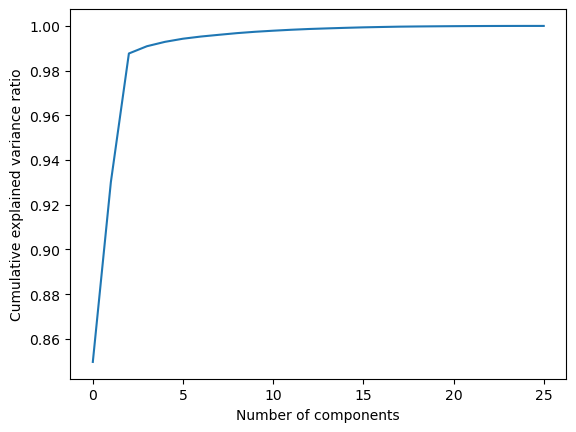

In [23]:
# Exclude the 'participant' column from the PCA analysis
X = joint_all_df.iloc[:, 1:]

# Perform PCA
pca = PCA()
pca.fit(X)

# Calculate the explained variance ratio for each principal component
variance_ratio = pca.explained_variance_ratio_

# Print the cumulative explained variance ratio for each number of components
print('Cumulative explained variance ratio:')
cumulative_variance_ratio = np.cumsum(variance_ratio)
for i, ratio in enumerate(cumulative_variance_ratio):
    print(f'{i+1} components: {ratio:.3f}')

# Plot the cumulative explained variance ratio
plt.plot(cumulative_variance_ratio)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance ratio')
plt.show()

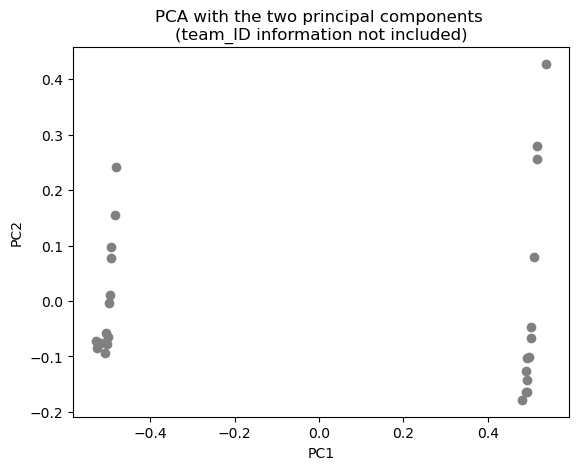

In [24]:
# Transform the data onto the first two principal components
X_pca = pca.transform(X)

# Plot each row with the first two principal components
for i, row in enumerate(X_pca):
    plt.scatter(row[0], row[1], label=joint_all_df['participant'][i], c='grey')

plt.xlabel('PC1')
plt.ylabel('PC2')
# plt.legend()
plt.title('PCA with the two principal components \n(team_ID information not included)')
plt.show()

## 9. Outlier identification from the PCA result (no team information)

**We define an outlier as a point that is more than two standard deviations away from the mean Euclidean distance**

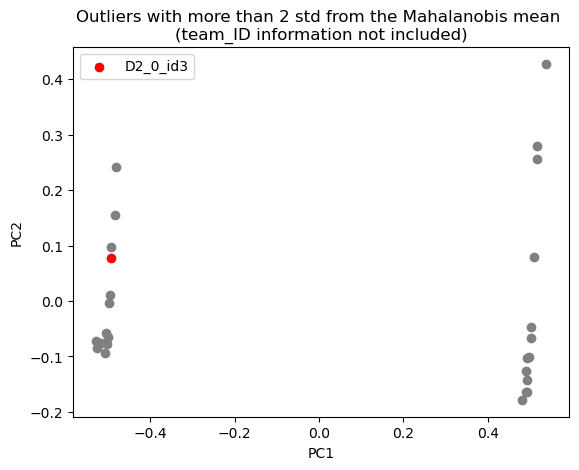

In [25]:
# Transform the data onto the first two principal components
X_pca = pca.transform(X)

# Calculate the center of the point cloud
center = np.mean(X_pca, axis=0)

# Calculate the Mahalanobis distance for each point
inv_cov = np.linalg.inv(np.cov(X_pca.T))
dist = [mahalanobis(x, center, inv_cov) for x in X_pca]

# Calculate the Euclidean distance for each point
# dist = [euclidean(x, center) for x in X_pca]

# Plot each row with the first two principal components and highlight outliers
for i, row in enumerate(X_pca):
    if dist[i] > np.mean(dist) + 2*np.std(dist):
        plt.scatter(row[0], row[1], label=joint_all_df['participant'][i], c='red')
    else:
        plt.scatter(row[0], row[1], c='grey')

plt.xlabel('PC1')
plt.ylabel('PC2')

# Create a custom legend for the red labels only
red_labels = [joint_all_df['participant'][i] for i in range(len(joint_all_df)) if dist[i] > np.mean(dist) + 2*np.std(dist)]
plt.legend(handles=[plt.scatter([], [], label=label, c='red') for label in red_labels], loc='best')

plt.title('Outliers with more than 2 std from the Mahalanobis mean \n(team_ID information not included)')
plt.show()

**We define an outlier as a point that is more than one standard deviations away from the mean Euclidean distance**

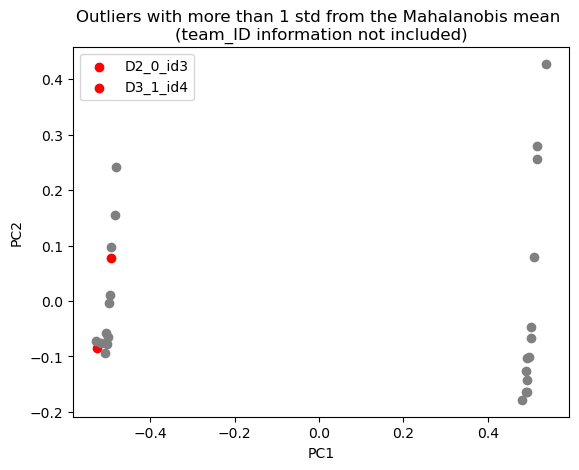

In [26]:
# Transform the data onto the first two principal components
X_pca = pca.transform(X)

# Calculate the center of the point cloud
center = np.mean(X_pca, axis=0)

# Calculate the Mahalanobis distance for each point
inv_cov = np.linalg.inv(np.cov(X_pca.T))
dist = [mahalanobis(x, center, inv_cov) for x in X_pca]

# Calculate the Euclidean distance for each point
# dist = [euclidean(x, center) for x in X_pca]

# Plot each row with the first two principal components and highlight outliers
for i, row in enumerate(X_pca):
    if dist[i] > np.mean(dist) + 1*np.std(dist):
        plt.scatter(row[0], row[1], label=joint_all_df['participant'][i], c='red')
    else:
        plt.scatter(row[0], row[1], c='grey')

plt.xlabel('PC1')
plt.ylabel('PC2')

# Create a custom legend for the red labels only
red_labels = [joint_all_df['participant'][i] for i in range(len(joint_all_df)) if dist[i] > np.mean(dist) + 1*np.std(dist)]
plt.legend(handles=[plt.scatter([], [], label=label, c='red') for label in red_labels], loc='best')

plt.title('Outliers with more than 1 std from the Mahalanobis mean \n(team_ID information not included)')
plt.show()

**Check the outliers information**

In [27]:
for i in red_labels:
    outlier_df = datas[datas['participant'] == i]
    print('INDIVIDUAL:', i)
    print('Team_ID:', outlier_df['team_ID'].values[0])
    print('E4_nr:', outlier_df['E4_nr'].values[0])
    print("")

INDIVIDUAL: D2_0_id3
Team_ID: 3
E4_nr: A02B10

INDIVIDUAL: D3_1_id4
Team_ID: 9
E4_nr: A0306B



## 10. PCA for all participants with all information together (including team information)

Cumulative explained variance ratio:
1 components: 0.213
2 components: 0.343
3 components: 0.473
4 components: 0.578
5 components: 0.649
6 components: 0.716
7 components: 0.781
8 components: 0.846
9 components: 0.911
10 components: 0.976
11 components: 0.991
12 components: 0.998
13 components: 0.999
14 components: 0.999
15 components: 0.999
16 components: 0.999
17 components: 1.000
18 components: 1.000
19 components: 1.000
20 components: 1.000
21 components: 1.000
22 components: 1.000
23 components: 1.000
24 components: 1.000
25 components: 1.000
26 components: 1.000


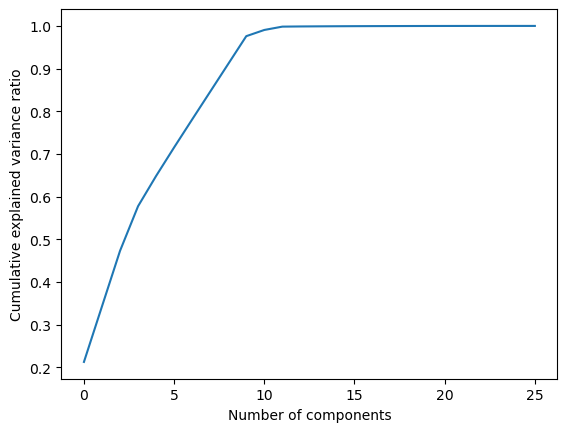

In [28]:
# Exclude the 'participant' column from the PCA analysis
X_team = joint_all_team_df.iloc[:, 1:]

# Perform PCA
pca_team = PCA()
pca_team.fit(X_team)

# Calculate the explained variance ratio for each principal component
variance_ratio_team = pca_team.explained_variance_ratio_

# Print the cumulative explained variance ratio for each number of components
print('Cumulative explained variance ratio:')
cumulative_variance_ratio_team = np.cumsum(variance_ratio_team)
for i, ratio in enumerate(cumulative_variance_ratio_team):
    print(f'{i+1} components: {ratio:.3f}')

# Plot the cumulative explained variance ratio
plt.plot(cumulative_variance_ratio_team)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance ratio')
plt.show()

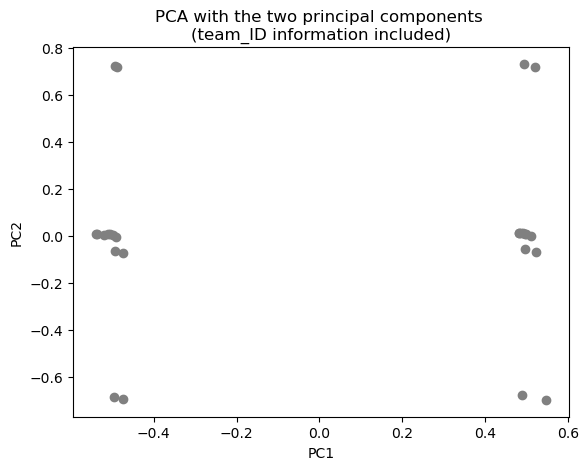

In [29]:
# Transform the data onto the first two principal components
X_pca_team = pca_team.transform(X_team)

# Plot each row with the first two principal components
for i, row in enumerate(X_pca_team):
    plt.scatter(row[0], row[1], label=joint_all_df['participant'][i], c='grey')

plt.xlabel('PC1')
plt.ylabel('PC2')
# plt.legend()
plt.title('PCA with the two principal components \n(team_ID information included)')
plt.show()

## 11. Outlier identification from the PCA result (including team information)

**We define an outlier as a point that is more than two standard deviations away from the mean Euclidean distance**

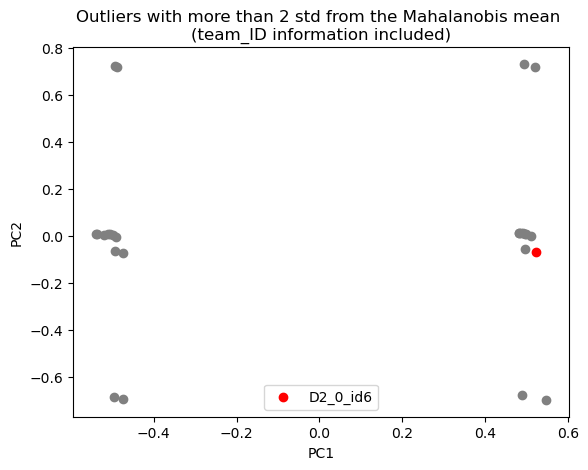

In [30]:
# Transform the data onto the first two principal components
X_pca_team = pca_team.transform(X_team)

# Calculate the center of the point cloud
center_team = np.mean(X_pca_team, axis=0)

# Calculate the Mahalanobis distance for each point
inv_cov_team = np.linalg.inv(np.cov(X_pca_team.T))
dist_team = [mahalanobis(x, center_team, inv_cov_team) for x in X_pca_team]

# Calculate the Euclidean distance for each point
# dist_team = [euclidean(x, center_team) for x in X_pca_team]

# Plot each row with the first two principal components and highlight outliers
for i, row in enumerate(X_pca_team):
    if dist_team[i] > np.mean(dist_team) + 2*np.std(dist_team):
        plt.scatter(row[0], row[1], label=joint_all_team_df['participant'][i], c='red')
    else:
        plt.scatter(row[0], row[1], c='grey')

plt.xlabel('PC1')
plt.ylabel('PC2')

# Create a custom legend for the red labels only
red_labels_team = [joint_all_team_df['participant'][i] for i in range(len(joint_all_team_df)) if dist_team[i] > np.mean(dist_team) + 2*np.std(dist_team)]
plt.legend(handles=[plt.scatter([], [], label=label, c='red') for label in red_labels_team], loc='best')

plt.title('Outliers with more than 2 std from the Mahalanobis mean \n(team_ID information included)')
plt.show()

**We define an outlier as a point that is more than one standard deviations away from the mean Euclidean distance**

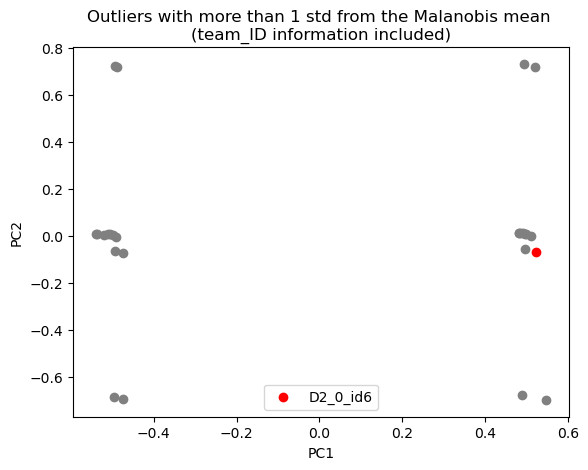

In [31]:
# Transform the data onto the first two principal components
X_pca_team = pca_team.transform(X_team)

# Calculate the center of the point cloud
center_team = np.mean(X_pca_team, axis=0)

# Calculate the Mahalanobis distance for each point
inv_cov_team = np.linalg.inv(np.cov(X_pca_team.T))
dist_team = [mahalanobis(x, center_team, inv_cov_team) for x in X_pca_team]

# Calculate the Euclidean distance for each point
# dist_team = [euclidean(x, center_team) for x in X_pca_team]

# Plot each row with the first two principal components and highlight outliers
for i, row in enumerate(X_pca_team):
    if dist_team[i] > np.mean(dist_team) + 1*np.std(dist_team):
        plt.scatter(row[0], row[1], label=joint_all_team_df['participant'][i], c='red')
    else:
        plt.scatter(row[0], row[1], c='grey')

plt.xlabel('PC1')
plt.ylabel('PC2')

# Create a custom legend for the red labels only
red_labels_team = [joint_all_team_df['participant'][i] for i in range(len(joint_all_team_df)) if dist_team[i] > np.mean(dist_team) + 1*np.std(dist_team)]
plt.legend(handles=[plt.scatter([], [], label=label, c='red') for label in red_labels_team], loc='best')

plt.title('Outliers with more than 1 std from the Malanobis mean \n(team_ID information included)')
plt.show()

**Check the outliers information**

In [32]:
for i in red_labels_team:
    outlier_df = datas[datas['participant'] == i]
    print('INDIVIDUAL:', i)
    print('Team_ID:', outlier_df['team_ID'].values[0])
    print('E4_nr:', outlier_df['E4_nr'].values[0])
    print("")

INDIVIDUAL: D2_0_id6
Team_ID: 2
E4_nr: A02FC2



## 12. Check if there is some type of clustering because of the team

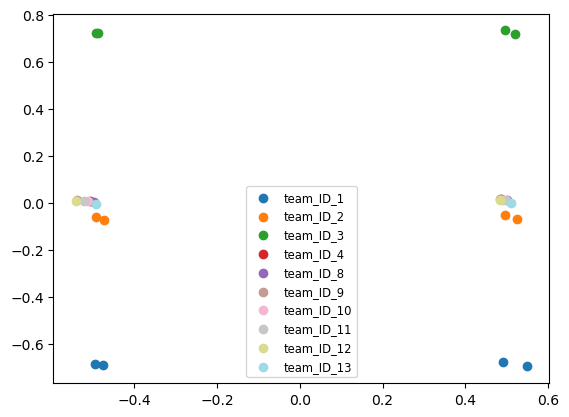

In [33]:
pca_team_df = pd.DataFrame(data=X_pca_team[:, :2], columns=['PC1', 'PC2'])
pca_team_df = pd.concat([pca_team_df, joint_all_team_df], axis=1)

# Get a list of unique team IDs
team_ids = joint_all_team_df.columns.tolist()[-10:]

# Set up a colormap for the team IDs
colors = plt.cm.tab20(np.linspace(0, 1, len(team_ids)))

# Plot the PCA result with colored points
fig, ax = plt.subplots()
for i, team_id in enumerate(team_ids):
    idx = pca_team_df[team_id] == 1
    ax.scatter(pca_team_df.loc[idx, 'PC1'], pca_team_df.loc[idx, 'PC2'], color=colors[i], label=team_id)

ax.legend(fontsize='small')
plt.show()

In [34]:
## NOT FUNCTIONAL

# Plot each row with the first two principal components and color by team_ID
# unique_teams = sorted(joint_all_team_df['team_ID'].unique())
# colors = plt.cm.get_cmap('tab10')(np.linspace(0, 1, len(unique_teams)))

# fig, ax = plt.subplots()

# for i, team in enumerate(unique_teams):
#     mask = joint_all_team_df['team_ID'] == team
#     ax.scatter(X_pca_team[mask, 0], X_pca_team[mask, 1], label=team, c=[colors[i]], alpha=0.7)

# ax.set_xlabel('PC1')
# ax.set_ylabel('PC2')
# ax.legend(fontsize=8, loc='best')
# plt.title('PCA with team_ID information')
# plt.show()

## 13. Check if there is some type of clustering because of the puzzler

**No team_ID information included**

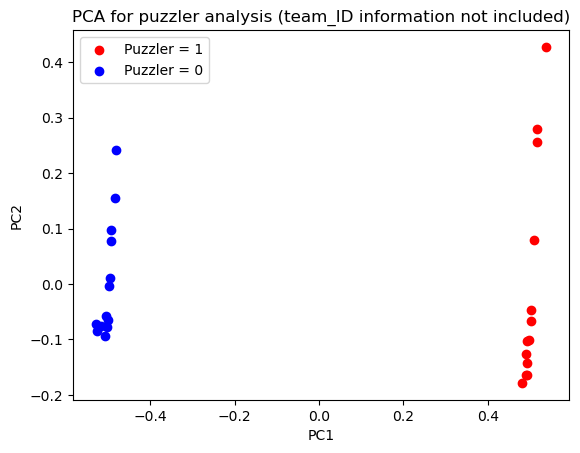

In [35]:
# Plot each row with the first two principal components and color points based on the value of 'puzzler'
plt.scatter(X_pca[joint_all_df['puzzler']==1, 0], X_pca[joint_all_df['puzzler']==1, 1], label='Puzzler = 1', c='red')
plt.scatter(X_pca[joint_all_df['puzzler']==0, 0], X_pca[joint_all_df['puzzler']==0, 1], label='Puzzler = 0', c='blue')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.title('PCA for puzzler analysis (team_ID information not included)')
plt.show()

**Team_ID information included**

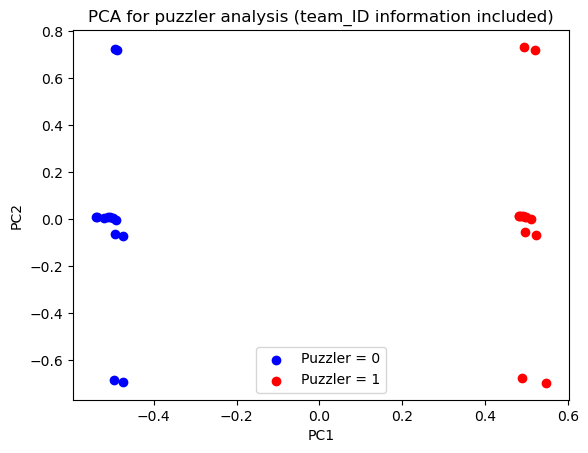

In [36]:
# Different results depending on being solver or instructor
X_pca_team_puzzler1 = X_pca_team[joint_all_team_df['puzzler']==1, :]
X_pca_team_puzzler0 = X_pca_team[joint_all_team_df['puzzler']==0, :]

# Plot each row with the first two principal components
plt.scatter(X_pca_team_puzzler0[:, 0], X_pca_team_puzzler0[:, 1], c='blue', label='Puzzler = 0')
plt.scatter(X_pca_team_puzzler1[:, 0], X_pca_team_puzzler1[:, 1], c='red', label='Puzzler = 1')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc='best')
plt.title('PCA for puzzler analysis (team_ID information included)')
plt.show()

## 14. SOM implementation (no team_ID information included)

C:\Users\minij\anaconda3\envs\DTU\lib\site-packages\minisom.py:384: ComplexWarning: Casting complex values to real discards the imaginary part
  self._weights[i, j] = c1*pc[:, pc_order[0]] + \


 [ 1065 / 5000 ]  21% - 0:00:00 left 

 [ 2284 / 5000 ]  46% - 0:00:00 left 

 [ 3485 / 5000 ]  70% - 0:00:00 left 

 [ 4813 / 5000 ]  96% - 0:00:00 left 

 [ 5000 / 5000 ] 100% - 0:00:00 left 
 quantization error: 0.005212969451766302


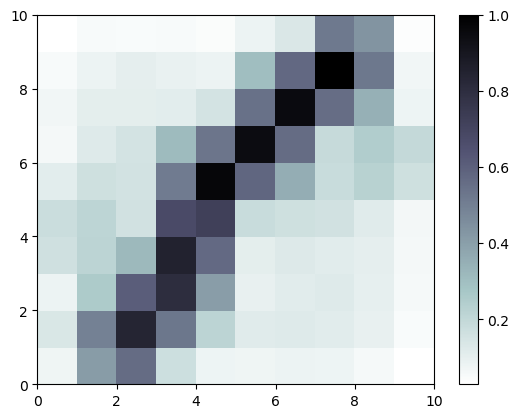

In [37]:
som = MiniSom(10, 10, X.values.shape[1], sigma=2.0, learning_rate=0.5)
X_array = np.array(X.values).astype(float)
som.pca_weights_init(X_array)
som.train_random(X_array, 5000, verbose=True)

# Plot the U-matrix
plt.pcolor(som.distance_map().T, cmap='bone_r')
plt.colorbar()

plt.show()

The color of the U-matrix represents the distance between neurons on the SOM:

- When the U-matrix value is close to 1, it means that the neurons in that location have high dissimilarity or distance to their neighbors.
- On the other hand, when the U-matrix value is close to 0, it indicates that the neurons in that location have high similarity or are close to their neighbors.

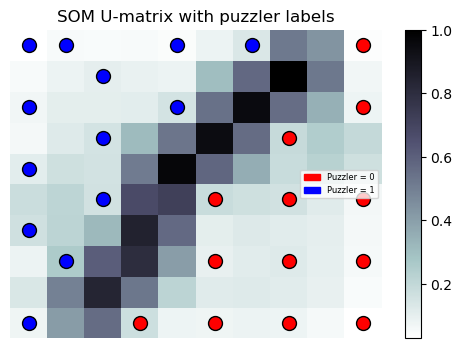

In [38]:
# Setting the labels with puzzler information
puzzler_target = X_array[:, -13]

# Create the U-matrix plot with class labels
plt.figure(figsize=(6, 4))
plt.pcolor(som.distance_map().T, cmap='bone_r')   # Plot the U-matrix

# Plot the points and add legend
red_patch = mpatches.Patch(color='red', label='Puzzler = 0')
blue_patch = mpatches.Patch(color='blue', label='Puzzler = 1')
plt.legend(handles=[red_patch, blue_patch], fontsize=6, loc='best')

for i, x in enumerate(X_array):
    w = som.winner(x)  # get the winner neuron for the data point
    if puzzler_target[i] == 0:
        plt.plot(w[0] + 0.5, w[1] + 0.5, 'o', color='red', markeredgecolor='black', markersize=10)  # mark the cell with red for class 0
    else:
        plt.plot(w[0] + 0.5, w[1] + 0.5, 'o', color='blue', markeredgecolor='black', markersize=10)  # mark the cell with blue for class 1
plt.axis('off')
plt.colorbar()
# Set the plot title and axis labels
plt.title('SOM U-matrix with puzzler labels')
plt.show()

## 15. SOM implementation (team_ID information included)

 [ 7000 / 7000 ] 100% - 0:00:00 left 

C:\Users\minij\anaconda3\envs\DTU\lib\site-packages\minisom.py:536: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(-2 * cross_term + input_data_sq + weights_flat_sq.T)



 quantization error: 1.5552653226204738e-09


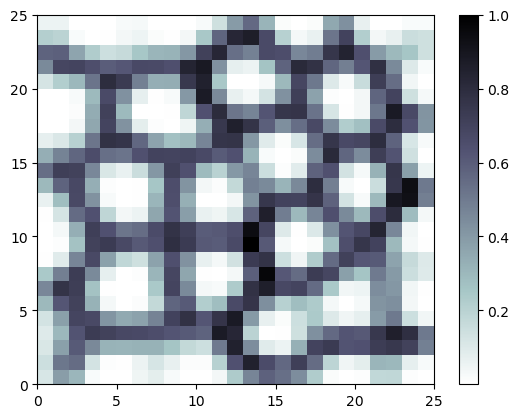

In [39]:
som_team = MiniSom(25, 25, X_team.values.shape[1], sigma=2.0, learning_rate=0.5)
X_team_array = np.array(X_team.values).astype(float)
som_team.pca_weights_init(X_team_array)
som_team.train_random(X_team_array, 7000, verbose=True)

# Plot the U-matrix
plt.pcolor(som_team.distance_map().T, cmap='bone_r')
plt.colorbar()

plt.show()

The color of the U-matrix represents the distance between neurons on the SOM:

- When the U-matrix value is close to 1, it means that the neurons in that location have high dissimilarity or distance to their neighbors.
- On the other hand, when the U-matrix value is close to 0, it indicates that the neurons in that location have high similarity or are close to their neighbors.

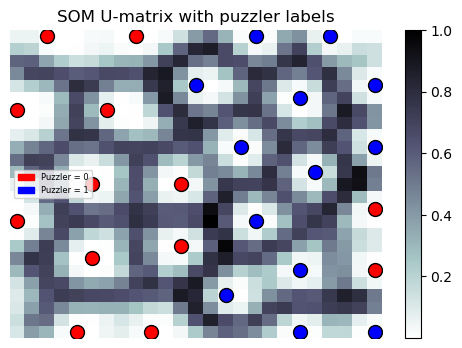

In [40]:
# Setting the labels with puzzler information
puzzler_target = X_team_array[:, -23]

# Create the U-matrix plot with class labels
plt.figure(figsize=(6, 4))
plt.pcolor(som_team.distance_map().T, cmap='bone_r')   # Plot the U-matrix

# Plot the points and add legend
red_patch = mpatches.Patch(color='red', label='Puzzler = 0')
blue_patch = mpatches.Patch(color='blue', label='Puzzler = 1')
plt.legend(handles=[red_patch, blue_patch], fontsize=6, loc='best')

for i, x in enumerate(X_team_array):
    w = som_team.winner(x)  # get the winner neuron for the data point
    if puzzler_target[i] == 0:
        plt.plot(w[0] + 0.5, w[1] + 0.5, 'o', color='red', markeredgecolor='black', markersize=10)  # mark the cell with red for class 0
    else:
        plt.plot(w[0] + 0.5, w[1] + 0.5, 'o', color='blue', markeredgecolor='black', markersize=10)  # mark the cell with blue for class 1
plt.axis('off')
plt.colorbar()
# Set the plot title and axis labels
plt.title('SOM U-matrix with puzzler labels')
plt.show()

In [41]:
part_IDs = joint_all_team_df['participant'].values
info_df = datas.drop(columns=['D', 'Sub_D', 'ID', 'Round', 'Phase', 'BVP', 'EDA', 'HR', 'TEMP', 'participant_ID', 'E4_nr'])
team_info = []

for part in part_IDs:
    team_info.append(info_df.loc[info_df["participant"] == part, "team_ID"].unique()[0])

part_team = dict(zip(part_IDs, team_info))

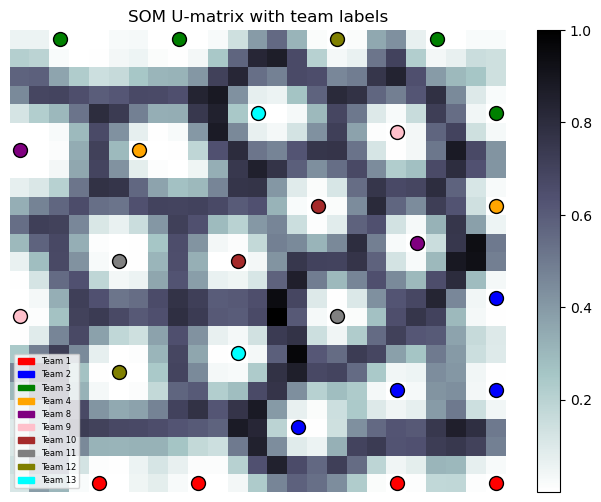

In [42]:
# Define a dictionary of colors for each label
color_dict = {1: 'red', 2: 'blue', 3: 'green', 4: 'orange', 8: 'purple', 9: 'pink', 10: 'brown', 11: 'gray', 12: 'olive', 13: 'cyan'}

# Create the U-matrix plot with class labels
plt.figure(figsize=(8, 6))
plt.pcolor(som_team.distance_map().T, cmap='bone_r')   # Plot the U-matrix

# Plot the points and add legend
patches = []
for label in color_dict.keys():
    patches.append(mpatches.Patch(color=color_dict[label], label='Team {}'.format(label)))
plt.legend(handles=patches, fontsize=6, loc='best')

for i, x in enumerate(X_team_array):
    w = som_team.winner(x)  # get the winner neuron for the data point
    label_index = team_info[i]
    color = color_dict[label_index]
    plt.plot(w[0] + 0.5, w[1] + 0.5, 'o', color=color, markeredgecolor='black', markersize=10)  # mark the cell with a color based on its label
plt.axis('off')
plt.colorbar()

# Set the plot title and axis labels
plt.title('SOM U-matrix with team labels')
plt.show()